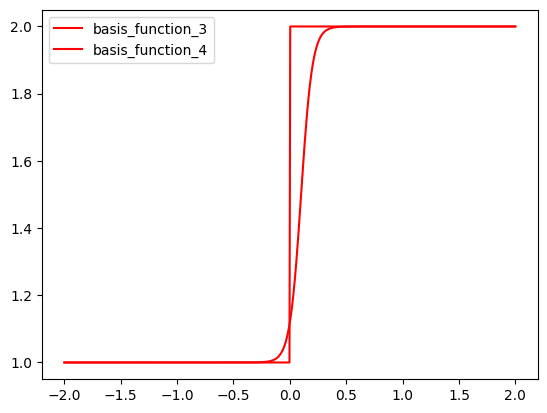

In [1]:
# Copyright (c) 2023, NVIDIA CORPORATION & AFFILIATES. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# import os
from os import walk, path
import csv
import matplotlib.pyplot as plt

from sympy import Symbol, Eq, Abs, StrictGreaterThan, StrictLessThan, And, tanh, Or, GreaterThan, LessThan, Not, sqrt, lambdify, Heaviside
import numpy as np
import torch

import modulus.sym
from modulus.sym.hydra import to_absolute_path, ModulusConfig
# from modulus.sym.utils.io import csv_to_dict
from modulus.sym.solver import Solver
from modulus.sym.domain import Domain
from modulus.sym.geometry import Parameterization
from modulus.sym.geometry.primitives_2d import Rectangle, Rectangle, Line
from modulus.sym.domain.constraint import (
    PointwiseBoundaryConstraint,
    PointwiseInteriorConstraint,
    IntegralBoundaryConstraint,
)

from modulus.sym.domain.inferencer import PointwiseInferencer
from modulus.sym.domain.monitor import PointwiseMonitor
from modulus.sym.key import Key
from modulus.sym.node import Node
from modulus.sym.eq.pdes.navier_stokes import NavierStokes
from modulus.sym.eq.pdes.basic import NormalDotVec
from modulus.sym.models.fourier_net import FourierNetArch
from modulus.sym.utils.io.vtk import var_to_polyvtk
from ansysValidator import ansysValidator
from dataConstraint import dataConstraint        

x = Symbol("x")

limits_x = [-1, 0.1]
maxLen = 20
grad = 10
gradC = 10
overlap=0.0
basis_function_1 = 0.5 * (tanh(grad * (0 + limits_x[0] - x)) + tanh(grad * (x + maxLen + limits_x[0])))
basis_function_2 = 0.25 * (tanh(gradC * (maxLen - (limits_x[0]-overlap) - x)) + tanh(gradC * (x + 0 - (limits_x[0]-overlap)))) * (tanh(gradC * (0 + (limits_x[1]+overlap) - x)) + tanh(gradC * (x + maxLen + (limits_x[1]+overlap))))
basis_function_3 = 0.5 * (tanh(grad * (maxLen -limits_x[1] - x)) + tanh(grad * (x + 0 - limits_x[1]))) +1

basis_function_4 = Heaviside(x) + 1

# plot the basis functions for visualization
basis_function_1_lf = lambdify(x, basis_function_1, "numpy")
basis_function_2_lf = lambdify(x, basis_function_2, "numpy")
basis_function_3_lf = lambdify(x, basis_function_3, "numpy")
basis_function_4_lf = lambdify(x, basis_function_4, "numpy")
y_vals = np.linspace(-2, 2, 600)

out_bf_1 = basis_function_1_lf(y_vals)
out_bf_2 = basis_function_2_lf(y_vals)
out_bf_3 = basis_function_3_lf(y_vals)
out_bf_4 = basis_function_4_lf(y_vals)

plt.figure()
# plt.plot(y_vals, out_bf_1, label="basis_function_1", color="blue")
# plt.plot(y_vals, out_bf_2, label="basis_function_2", color="green")
plt.plot(y_vals, out_bf_3, label="basis_function_3", color="red")
plt.plot(y_vals, out_bf_4, label="basis_function_4", color="red")
# plt.axvline(x = 0, color = 'y', label = 'axvline - full height')
# plt.axvline(x = -1, color = 'y', label = 'axvline - full height')

plt.legend()
plt.savefig(to_absolute_path("./basis_function_viz_" + str(overlap) + ".png"))

In [8]:
for i in range(10):
    if i%4 == 0:
        print(i)

0
4
8


In [4]:
import shutil
valueList = [["\"testDir@1000\"", 1000, False, True],
             ["\"testDir@2000\"", 1000, False, True]
            ]
i=1
print(valueList[i][0])
source_dir = "./outputs/" + str(valueList[i][0][1:-1])
print(source_dir)
destination_dir = "./outputs/" + valueList[i+1][0][1:-1]
shutil.copytree(source_dir, destination_dir)

"testDir@2000"
./outputs/testDir@2000


IndexError: list index out of range

In [23]:
from modulus.sym.hydra import to_absolute_path
from sympy import Symbol, GreaterThan, And
from os import path
from csv_rw import csv_to_dict
import numpy as np
from modulus.sym.domain.constraint import PointwiseConstraint
from sympy import Symbol, Eq, Abs, StrictGreaterThan, StrictLessThan, And, tanh, Or, GreaterThan, LessThan, Not, sqrt, lambdify, Heaviside


import numpy as np
import sympy
from typing import Callable, Union, List

from modulus.sym.utils.sympy import np_lambdify
from modulus.sym.constants import diff_str
from modulus.sym.geometry.helper import (
    _concat_numpy_dict_list,
    _sympy_sdf_to_sdf,
    _sympy_criteria_to_criteria,
    _sympy_func_to_func,
)


Re = Symbol("Re")
x, y = Symbol("x"), Symbol("y")
Lo, Ho = Symbol("Lo"), Symbol("Ho")

def dataConstraint(file_path, ansysVarNames, modulusVarNames, scales, skiprows=1, param=False, criteria=None):
    if path.exists(to_absolute_path(file_path)):
        mapping = {}
        for ansVarName, modulusVarName in zip(ansysVarNames, modulusVarNames):
            mapping[ansVarName] = modulusVarName

        openfoam_var = csv_to_dict(to_absolute_path(file_path), mapping, skiprows=skiprows)

        if param!=False:
            parameterRanges = param               
        
            openfoam_var.update({"Re": np.full_like(openfoam_var["x"], parameterRanges[Re])})
            openfoam_var.update({"Lo": np.full_like(openfoam_var["x"], parameterRanges[Lo])})
            openfoam_var.update({"Ho": np.full_like(openfoam_var["x"], parameterRanges[Ho])})
        
        for key, scale in zip(modulusVarNames, scales):
            openfoam_var[key] += scale[0]
            openfoam_var[key] /= scale[1]
            

        invarKeys = ["x", "y", "Re", "Lo", "Ho"]
        outvarKeys = modulusVarNames[:-2]

        openfoam_invar_numpy = {
            key: value
            for key, value in openfoam_var.items()
            if key in invarKeys

        }

        openfoam_outvar_numpy = {
            key: value for key, value in openfoam_var.items() if key in outvarKeys
        }
        
        openfoam_invar_numpy_t={}
        openfoam_outvar_numpy_t={}
        
        criteria = And(GreaterThan(x, 11.95), GreaterThan(y, 0))
        
        
        if criteria is not None:
            
            sdfInvarKeys = ["x", "y"]
            sdfParamKeys = ["Re", "Lo", "Ho"]
        
            sdfInvar = {
                key: value
                for key, value in openfoam_var.items()
                if key in sdfInvarKeys
            }
            
            sdfParam = {
                key: value
                for key, value in openfoam_var.items()
                if key in sdfParamKeys
            }
            
            if isinstance(criteria, sympy.Basic):
                criteria = _sympy_criteria_to_criteria(criteria)
            elif isinstance(criteria, Callable):
                pass
            else:
                raise TypeError(
                    "criteria type is not supported: " + str(type(criteria))
                )
        
        crit = criteria(sdfInvar, sdfParam)
        
        return crit, sdfInvar, sdfInvar["x"][crit > 0]
        # y_limit = -0.5
        # y_limit_offset = 0.01
        # x_limit = [-4, -2, 0, 4, 8]
        
        # for key in openfoam_invar_numpy.keys():
        #     openfoam_invar_numpy_t[key] = np.copy(openfoam_invar_numpy[key][(openfoam_invar_numpy["y"]<-0.147) & (openfoam_invar_numpy["y"]>-0.187) & (((openfoam_invar_numpy["x"]>-0.187) & (openfoam_invar_numpy["x"]>-0.187)) | ((openfoam_invar_numpy["x"]>-0.187) & (openfoam_invar_numpy["x"]>-0.187)) | ((openfoam_invar_numpy["x"]>-0.187) & (openfoam_invar_numpy["x"]>-0.187)) | ((openfoam_invar_numpy["x"]>-0.187) & (openfoam_invar_numpy["x"]>-0.187))) ])
        #     openfoam_invar_numpy_t[key] = openfoam_invar_numpy_t[key].reshape((openfoam_invar_numpy_t[key].shape[0], 1))
        # for key in openfoam_outvar_numpy.keys():
        #     openfoam_outvar_numpy_t[key] = np.copy(openfoam_outvar_numpy[key][(openfoam_invar_numpy["y"]<-0.147) & (openfoam_invar_numpy["y"]>-0.187)])
        #     openfoam_outvar_numpy_t[key]=openfoam_outvar_numpy_t[key].reshape((openfoam_outvar_numpy_t[key].shape[0], 1))
        # openfoam_invar_numpy=openfoam_invar_numpy_t
        # openfoam_outvar_numpy=openfoam_outvar_numpy_t

In [24]:
from readParameters import readParametersFromFileName

ansysVarNames = ("Pressure", "Velocity:0", "Velocity:1", "Points:0", "Points:1")
modulusVarNames = ("p_d", "u_d", "v_d", "x", "y")
scales = ((0,1), (0,1), (0,1), (0,1), (-0.5,1))
additionalConstraints=None #{"continuity": 0, "momentum_x": 0, "momentum_y": 0}

param_ranges = {
    Re: (100, 1000),
    Lo: (0.1, 1),
    Ho: (0.1, 0.5),
    }

file_path = to_absolute_path("./ansys/data100/DP5_999,9999999999975-0,64727272727272711-0,11636363636363636.csv")
dataParameterRange, shortName = readParametersFromFileName(fileName="DP5_999,9999999999975-0,64727272727272711-0,11636363636363636.csv", parameterDict=param_ranges, generateNameString=True)
crit, invar, invarCrit = dataConstraint(file_path, ansysVarNames, modulusVarNames, scales, skiprows=1, param=dataParameterRange)

In [21]:
from modulus.sym.hydra import to_absolute_path
from sympy import Symbol
from os import path
from csv_rw import csv_to_dict
import numpy as np
from modulus.sym.domain.constraint import PointwiseConstraint
from sympy import Symbol, Eq, Abs, StrictGreaterThan, StrictLessThan, And, tanh, Or, GreaterThan, LessThan, Not, sqrt, lambdify, Heaviside

# from modulus.sym.utils.sympy import np_lambdify
# from modulus.sym.constants import diff_str
from modulus.sym.geometry.helper import (
    _concat_numpy_dict_list,
    _sympy_criteria_to_criteria,
)


Re = Symbol("Re")
x, y = Symbol("x"), Symbol("y")
Lo, Ho = Symbol("Lo"), Symbol("Ho")

def dataConstraint(file_path, ansysVarNames, modulusVarNames, scales, batches, skiprows=1, param=False, nonDim=None, additionalConstraints=None, criteria=None, geo=None, lambdaFn=NotImplemented):
    if path.exists(to_absolute_path(file_path)):
        mapping = {}
        for ansVarName, modulusVarName in zip(ansysVarNames, modulusVarNames):
            mapping[ansVarName] = modulusVarName

        openfoam_var = csv_to_dict(to_absolute_path(file_path), mapping, skiprows=skiprows)

        if param!=False:
            parameterRanges = param               
        
            openfoam_var.update({"Re": np.full_like(openfoam_var["x"], parameterRanges[Re])})
            openfoam_var.update({"Lo": np.full_like(openfoam_var["x"], parameterRanges[Lo])})
            openfoam_var.update({"Ho": np.full_like(openfoam_var["x"], parameterRanges[Ho])})
        
        for key, scale in zip(modulusVarNames, scales):
            openfoam_var[key] += scale[0]
            openfoam_var[key] /= scale[1]
            

        invarKeys = ["x", "y", "Re", "Lo", "Ho"]
        outvarKeys = modulusVarNames[:-2]
        
        if additionalConstraints != None:
            for key, value in additionalConstraints.items():
                openfoam_var.update({key: np.full_like(openfoam_var["x"], value)})
                outvarKeys += (key,) 

        openfoam_invar_numpy = {
            key: value
            for key, value in openfoam_var.items()
            if key in invarKeys

        }

        openfoam_outvar_numpy = {
            key: value for key, value in openfoam_var.items() if key in outvarKeys
        }
        
        

            
        lambda_weighting={"u_d": np.full_like(openfoam_outvar_numpy["u_d"], 0.1), "v_d": np.full_like(openfoam_outvar_numpy["v_d"], 0.1), "p_d": np.full_like(openfoam_outvar_numpy["p_d"], 0.1)}
        
        
        if geo!=None or criteria!=None:
            splitInvarKeys = ["x", "y"]
            splitParamKeys = ["Re", "Lo", "Ho"]
        
            splitInvar = {
                key: value
                for key, value in openfoam_var.items()
                if key in splitInvarKeys
            }
            
            splitParam = {
                key: value
                for key, value in openfoam_var.items()
                if key in splitParamKeys
            }
            
            if geo!=None:
                sdf = geo.sdf(splitInvar, splitParam)
                # lambdaFn = 1*tanh(20 * var)
                
                lambdaFnlf = lambdify(Symbol("sdf"), lambdaFn, "numpy")
                
                lambdaNumpy = lambdaFnlf(sdf['sdf'])
                
                for key in additionalConstraints.keys():
                    lambda_weighting[key] = lambdaNumpy
            
            if criteria!=None:
                criteria = _sympy_criteria_to_criteria(criteria)
        
                criteriaNumpy = criteria(splitInvar, splitParam)
                
                for invarKey in openfoam_invar_numpy.keys():
                    openfoam_invar_numpy[invarKey]=openfoam_invar_numpy[invarKey][criteriaNumpy>0]
                
                for outvarKey in openfoam_outvar_numpy.keys():
                    openfoam_outvar_numpy[outvarKey]=openfoam_outvar_numpy[outvarKey][criteriaNumpy>0]
        

        return openfoam_invar_numpy, openfoam_outvar_numpy, criteriaNumpy
    else:
        print("Missing Data: ", file_path)

In [22]:
from readParameters import readParametersFromFileName
from sympy import Symbol, Eq, Abs, StrictGreaterThan, StrictLessThan, And, tanh, Or, GreaterThan, LessThan, Not

ansysVarNames = ("Pressure", "Velocity:0", "Velocity:1", "Points:0", "Points:1")
modulusVarNames = ("p_d", "u_d", "v_d", "x", "y")
scales = ((0,1), (0,1), (0,1), (0,1), (-0.5,1))
additionalConstraints=None #{"continuity": 0, "momentum_x": 0, "momentum_y": 0}

param_ranges = {
    Re: (100, 1000),
    Lo: (0.1, 1),
    Ho: (0.1, 0.5),
    }

criteria = And(GreaterThan(x, 11.95), GreaterThan(y, 0))

file_path = to_absolute_path("./ansys/data100/DP5_999,9999999999975-0,64727272727272711-0,11636363636363636.csv")
dataParameterRange, shortName = readParametersFromFileName(fileName="DP5_999,9999999999975-0,64727272727272711-0,11636363636363636.csv", parameterDict=param_ranges, generateNameString=True)
invar_numpy, outvar_numpy, criteria = dataConstraint(file_path, ansysVarNames, modulusVarNames, scales, batches=10, skiprows=1, param=dataParameterRange, additionalConstraints=additionalConstraints, criteria=criteria)

In [23]:
for key in invar_numpy.keys():
    print(key + " shape: ", invar_numpy[key].shape)

for key in outvar_numpy.keys():
    print(key + " shape: ", outvar_numpy[key].shape)
    
print(criteria.shape)

x shape:  (14,)
y shape:  (14,)
Re shape:  (14,)
Lo shape:  (14,)
Ho shape:  (14,)
p_d shape:  (14,)
u_d shape:  (14,)
v_d shape:  (14,)
(74531, 1)


In [24]:
from sympy import Symbol, Eq, Abs, StrictGreaterThan, StrictLessThan, And, tanh, Or, GreaterThan, LessThan, Not, sqrt, lambdify, Heaviside

# from modulus.sym.utils.sympy import np_lambdify
# from modulus.sym.constants import diff_str
from modulus.sym.geometry.helper import (
    _concat_numpy_dict_list,
    _sympy_criteria_to_criteria,
)


Re = Symbol("Re")

In [26]:
print(Re)

Re
